In [ ]:
Independent Evaluation 
-BEST IDEA IS TO GATHER INCORRECT, AND CORRECT DATA TO TEST.

% of certainty

i want null / no sign / shape / type

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import matplotlib as plt

2024-04-21 22:23:45.932337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Custom preprocessing function
def preprocess_input(x):
    return x / 255.0

In [3]:
# Set the path to your dataset and define the image size
dataset_path = 'trafficsigns_dataset'
img_size = (28, 28)

In [4]:
# Create lists to store the image paths, shapes, and types
image_paths = []
shapes = []
types = []

In [5]:
for shape in os.listdir(dataset_path):
    shape_path = os.path.join(dataset_path, shape)
    for sign_type in os.listdir(shape_path):
        type_path = os.path.join(shape_path, sign_type)
        for image_file in os.listdir(type_path):
            image_path = os.path.join(type_path, image_file)
            image_paths.append(image_path)
            shapes.append(shape)
            types.append(sign_type)

# Encode the shape and type labels
shape_encoder = LabelEncoder()
type_encoder = LabelEncoder()

shape_labels = shape_encoder.fit_transform(shapes)
type_labels = type_encoder.fit_transform(types)

# Create a DataFrame with image paths, shape labels, and type labels
df = pd.DataFrame({
    'image_path': image_paths,
    'shape_label': shape_labels,
    'type_label': type_labels
})

In [6]:
# Split the data into train and validation sets
train_indices, val_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Create data generators for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

/tmp/ipykernel_184418/3420247451.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path)


Shape Accuracy: 0.9540540540540541
Type Accuracy: 0.9554054054054054


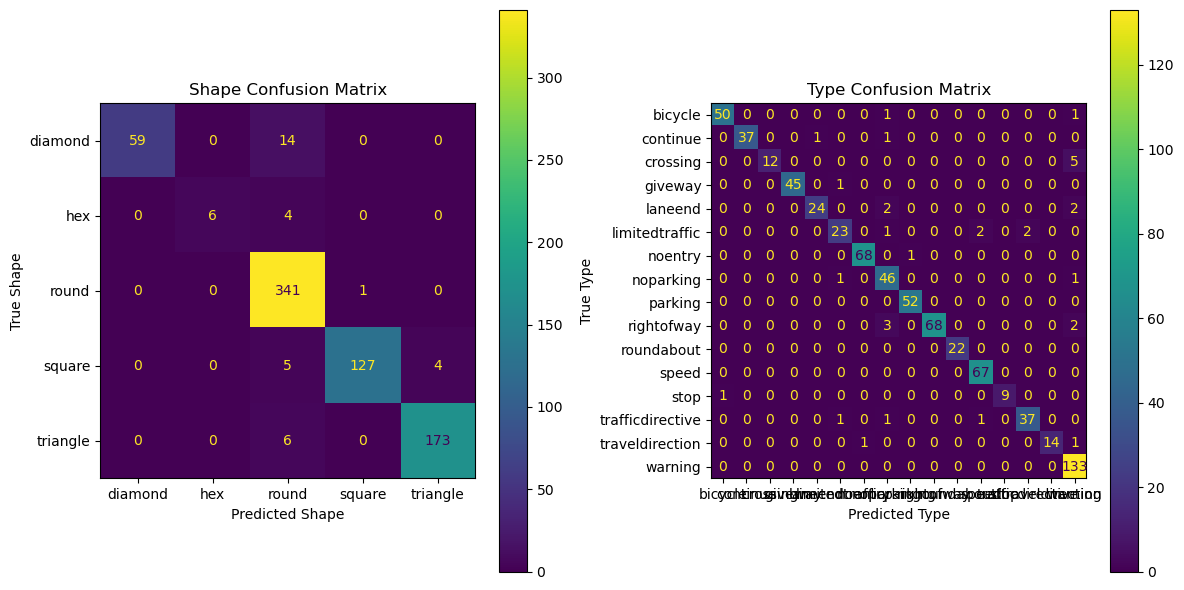

In [10]:
import imageio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load and preprocess the image data
def load_and_preprocess_image(image_path):
    img = imageio.imread(image_path)
    img = img / 255.0
    return img.flatten()

# Prepare the input data and labels
X_train = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[train_indices]['image_path']])
X_val = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[val_indices]['image_path']])

y_train_shape = df.iloc[train_indices]['shape_label'].values
y_train_type = df.iloc[train_indices]['type_label'].values
y_val_shape = df.iloc[val_indices]['shape_label'].values
y_val_type = df.iloc[val_indices]['type_label'].values

# Create Random Forest classifiers for shape and type
shape_rf = RandomForestClassifier(n_estimators=100, random_state=42)
type_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifiers
shape_rf.fit(X_train, y_train_shape)
type_rf.fit(X_train, y_train_type)

# Make predictions on the validation set
shape_pred = shape_rf.predict(X_val)
type_pred = type_rf.predict(X_val)

# Evaluate the Random Forest classifiers on the validation set
shape_acc = shape_rf.score(X_val, y_val_shape)
type_acc = type_rf.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

plt.tight_layout()
plt.show()

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

# Create a custom CNN model
input_shape = (28, 28, 3)
input_tensor = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

shape_output = Dense(len(shape_encoder.classes_), activation='softmax', name='shape')(x)
type_output = Dense(len(type_encoder.classes_), activation='softmax', name='type')(x)

model = Model(inputs=input_tensor, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam', loss={'shape': 'sparse_categorical_crossentropy', 'type': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=len(val_indices) // 32,
    epochs=10
)

Found 2959 validated image filenames.
Found 740 validated image filenames.
Epoch 1/10


2024-04-21 22:23:47.795298: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-04-21 22:23:47.927154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


91/92 [============================>.] - ETA: 0s - loss: 3.4392 - shape_loss: 1.0908 - type_loss: 2.3484 - shape_accuracy: 0.5917 - type_accuracy: 0.2705

2024-04-21 22:23:53.776753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 6s 60ms/step - loss: 3.4223 - shape_loss: 1.0840 - type_loss: 2.3383 - shape_accuracy: 0.5945 - type_accuracy: 0.2740 - val_loss: 1.8300 - val_shape_loss: 0.5194 - val_type_loss: 1.3106 - val_shape_accuracy: 0.8274 - val_type_accuracy: 0.6603
Epoch 2/10
92/92 [==============================] - 7s 76ms/step - loss: 1.5767 - shape_loss: 0.4528 - type_loss: 1.1240 - shape_accuracy: 0.8405 - type_accuracy: 0.6587 - val_loss: 0.6856 - val_shape_loss: 0.1819 - val_type_loss: 0.5037 - val_shape_accuracy: 0.9375 - val_type_accuracy: 0.8696
Epoch 3/10
92/92 [==============================] - 11s 121ms/step - loss: 0.9397 - shape_loss: 0.2467 - type_loss: 0.6931 - shape_accuracy: 0.9211 - type_accuracy: 0.7858 - val_loss: 0.3962 - val_shape_loss: 0.0960 - val_type_loss: 0.3001 - val_shape_accuracy: 0.9715 - val_type_accuracy: 0.9375
Epoch 4/10
92/92 [==============================] - 10s 112ms/step - loss: 0.6821 - shape_loss: 0.1742 - type_loss: 0.5079 -

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Select a random image path from the validation set
random_index = np.random.choice(val_indices)
image_path = df.iloc[random_index]['image_path']

# Load and preprocess the image
img = image.load_img(image_path, target_size=img_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make predictions
shape_pred, type_pred = model.predict(x)

# Get the predicted shape and type labels
shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]

# Print the predicted shape and type
print("Predicted Shape:", shape_label)
print("Predicted Type:", type_label)

# Display the tested image
plt.imshow(img)
plt.axis('off')
plt.title(f"Shape: {shape_label}, Type: {type_label}")
plt.show()

In [ ]:
# Evaluate the model on the validation set
val_loss, val_shape_loss, val_type_loss, val_shape_acc, val_type_acc = model.evaluate(val_generator, steps=len(val_indices) // 32)

# Print the validation metrics
print("Validation Loss:", val_loss)
print("Validation Shape Loss:", val_shape_loss)
print("Validation Type Loss:", val_type_loss)
print("Validation Shape Accuracy:", val_shape_acc)
print("Validation Type Accuracy:", val_type_acc)